# Experiment with Shifted ReLUs

Paper: https://arxiv.org/pdf/1511.07289.pdf
--- 

In [1]:
from fastai.script import *
from fastai.vision import *
torch.backends.cudnn.benchmark = True
from fastprogress import fastprogress
fastprogress.MAX_COLS = 80

In [2]:
import fastai
fastai.__version__

'1.0.47.post1'

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

## Get Data

In [4]:
from fastai import datasets

In [5]:
path = untar_data(URLs.IMAGENETTE_160)
tfms = get_transforms(do_flip=False)

In [6]:
size = 128 # from https://github.com/fastai/fastai/blob/master/examples/train_imagenette.py#L29
bs = 128
n_gpus = 1
workers = min(8, num_cpus()//n_gpus)

In [7]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imagenette-160/models'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/val'),
 PosixPath('/home/jupyter/.fastai/data/imagenette-160/train')]

In [8]:
data = (ImageList.from_folder(path).split_by_folder(valid='val')
            .label_from_folder().transform(([flip_lr(p=0.5)], []), size=size)
            .databunch(bs=bs, num_workers=workers)
#             .presize(size, scale=(0.35,1))
.normalize(imagenet_stats))

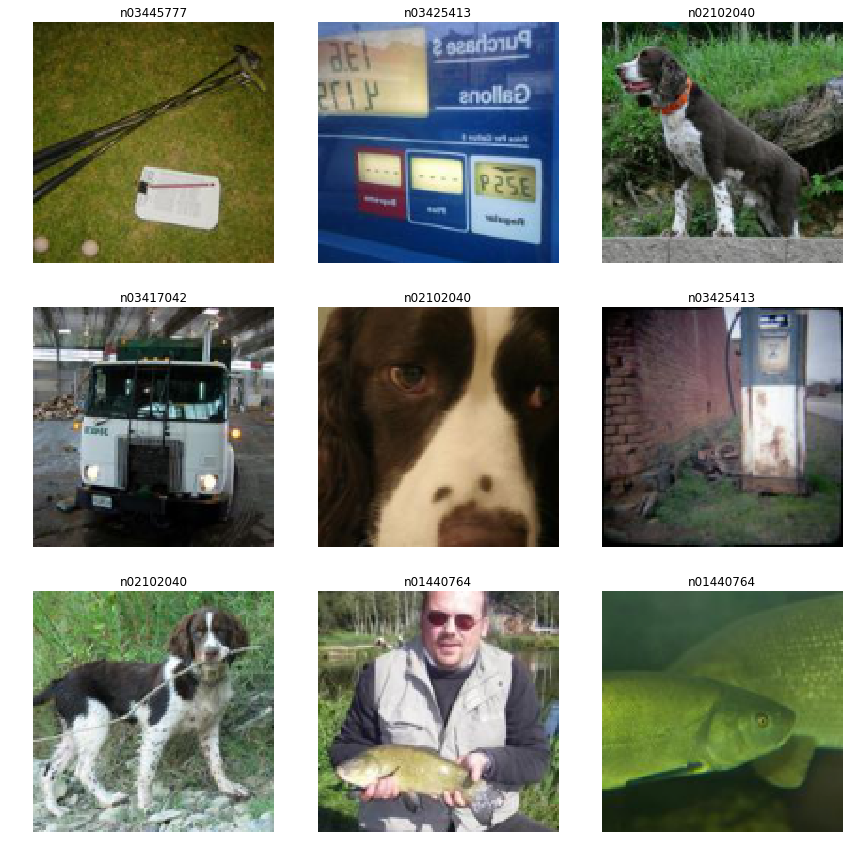

In [9]:
data.show_batch(rows=3)

In [10]:
class FastReLU(nn.Threshold):
    def __init__(self, threshold=0.0, value=0.0, bias= -0.5, inplace=False):
        super(FastReLU, self).__init__(threshold, value)
        
        self.threshold = threshold
        self.value = value
        self.inplace = inplace
        self.bias = bias
        
    def forward(self, input):
        return F.threshold(input, self.threshold, self.value, self.inplace) + self.bias
    
    def extra_repr(self):
        inplace_str = 'inplace' if self.inplace else ''
        return inplace_str

In [11]:
# sanity check, zero bias FastReLU should be the same as ReLU
test_list  = tensor([-0.1, 0, 0.5])
m, f = nn.ReLU(), FastReLU(bias=0.0)
m(test_list) == f(test_list)

tensor([1, 1, 1], dtype=torch.uint8)

In [12]:
m, f = nn.ReLU(), FastReLU(bias=0.5)
m(test_list) == f(test_list)

tensor([0, 0, 0], dtype=torch.uint8)

## Basic ResNet from torchvision

In [13]:
from torchvision.models import ResNet
from torchvision.models.resnet import conv1x1, conv3x3, BasicBlock, Bottleneck

In [35]:
class FastBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(FastBasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = FastReLU(inplace=True)
#         self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
    
class NoBN_FastBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(NoBN_FastBasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
#         self.bn1 = nn.BatchNorm2d(planes)
        self.relu = FastReLU(inplace=True)
#         self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
#         self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
#         out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
#         out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [28]:
class FastBottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(FastBottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = FastReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
    
class NoBN_FastBottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(NoBN_FastBottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
#         self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
#         self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
#         self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = FastReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
#         out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
#         out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
#         out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

## FastResNet

In [17]:
class FastResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(FastResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = FastReLU(inplace=True)
#         self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [27]:
class NoBN_FastResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(NoBN_FastResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
        self.relu = FastReLU(inplace=True)
#         self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
#         if zero_init_residual:
#             for m in self.modules():
#                 if isinstance(m, Bottleneck):
#                     nn.init.constant_(m.bn3.weight, 0)
#                 elif isinstance(m, BasicBlock):
#                     nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
#                 nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
#         x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

### Define Model Creating Functions

In [18]:
def fast_rn18(pretrained=False, **kwargs):
    model = FastResNet(FastBasicBlock, [2, 2, 2, 2], **kwargs)
    return model

In [30]:
def nobn_fast_rn18(pretrained=False, **kwargs):
    model = NoBN_FastResNet(NoBN_FastBasicBlock, [2, 2, 2, 2], **kwargs)
    return model

In [19]:
def base_rn18(pretrained=False, **kwargs):
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model

In [20]:
def fast_rn101(pretrained=False, **kwargs):
    model = FastResNet(FastBottleneck, [3, 4, 23, 3], **kwargs)
    return model

In [31]:
def nobn_fast_rn101(pretrained=False, **kwargs):
    model = NoBN_FastResNet(NoBN_FastBottleneck, [3, 4, 23, 3], **kwargs)
    return model

In [21]:
def base_rn101(pretrained=False, **kwargs):
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    return model

## Run Experiments

In [22]:
from statistics import mean
def average_perf(n, model_creator):
    """
    Build n custom learners from scratch and find average accuracy
    """
    acc_list = []
    
    for _ in range(n):
        custom_learn = cnn_learner(data, model_creator, metrics=accuracy)
        custom_learn.fit_one_cycle(5, 1e-2)
        acc_list.append(custom_learn.recorder.metrics[-1][0].item())
    print(f"Mean accuracy over {n} runs(s) is {mean(acc_list)}")
    return acc_list

# RN101 with FastReLU

In [23]:
acc_list = average_perf(1, fast_rn101)

epoch,train_loss,valid_loss,accuracy,time
0,2.490485,2.663430,0.104000,01:50
1,2.462046,2.341804,0.124000,01:42
2,2.386676,2.369000,0.134000,01:10
3,2.320802,2.273012,0.146000,00:52
4,2.288863,2.284762,0.150000,00:52


Mean accuracy over 1 runs(s) is 0.15000000596046448


### RN101 with No Batchnorm FastReLU

In [33]:
acc_list = average_perf(1, nobn_fast_rn101)

epoch,train_loss,valid_loss,accuracy,time
0,2.156389,2.088433,0.262000,00:21
1,2.081617,1.995780,0.288000,00:22
2,2.045686,2.656503,0.212000,00:22
3,1.982404,1.850515,0.354000,00:22
4,1.941965,1.835632,0.370000,00:22


Mean accuracy over 1 runs(s) is 0.3700000047683716


# RN101 with ReLU

In [24]:
acc_list = average_perf(1, base_rn101)

epoch,train_loss,valid_loss,accuracy,time
0,2.445912,2.261058,0.170000,00:52
1,2.329241,2.270334,0.194000,00:52
2,2.214886,2.134537,0.216000,00:52
3,2.129092,2.021026,0.278000,01:12
4,2.078145,1.988590,0.288000,01:22


Mean accuracy over 1 runs(s) is 0.2879999876022339


# RN18 with ReLU

In [25]:
acc_list = average_perf(5, base_rn18)

epoch,train_loss,valid_loss,accuracy,time
0,2.084496,1.697039,0.432000,00:19
1,1.771152,1.484637,0.514000,00:19
2,1.511781,1.255310,0.596000,00:19
3,1.347608,1.158639,0.616000,00:19
4,1.224585,1.141226,0.628000,00:16


epoch,train_loss,valid_loss,accuracy,time
0,2.074719,1.779654,0.428000,00:21
1,1.790640,1.520895,0.520000,00:21
2,1.543939,1.319095,0.552000,00:21
3,1.379378,1.259907,0.558000,00:21
4,1.272497,1.225282,0.588000,00:20


epoch,train_loss,valid_loss,accuracy,time
0,2.138576,1.756005,0.376000,00:21
1,1.834492,1.523011,0.472000,00:21
2,1.568250,1.329912,0.532000,00:21
3,1.397853,1.229457,0.588000,00:21
4,1.285373,1.201907,0.604000,00:20


epoch,train_loss,valid_loss,accuracy,time
0,2.101698,1.804109,0.394000,00:21
1,1.804023,1.476610,0.496000,00:21
2,1.557096,1.308751,0.578000,00:21
3,1.388419,1.233285,0.580000,00:21
4,1.281840,1.193982,0.608000,00:21


epoch,train_loss,valid_loss,accuracy,time
0,2.075336,1.731508,0.388000,00:21
1,1.802303,1.555159,0.494000,00:21
2,1.564582,1.331835,0.546000,00:21
3,1.376796,1.235447,0.570000,00:21
4,1.276656,1.209791,0.572000,00:21


Mean accuracy over 5 runs(s) is 0.6


# RN18 with FastReLU

In [26]:
acc_list = average_perf(5, fast_rn18)

epoch,train_loss,valid_loss,accuracy,time
0,2.251183,2.083540,0.320000,00:22
1,1.912028,1.569351,0.472000,00:22
2,1.627645,1.384527,0.526000,00:22
3,1.449601,1.209423,0.606000,00:19
4,1.336467,1.186583,0.602000,00:22


epoch,train_loss,valid_loss,accuracy,time
0,2.244226,1.977816,0.308000,00:22
1,1.925843,1.611032,0.412000,00:22
2,1.653362,1.411597,0.510000,00:22
3,1.447392,1.300439,0.562000,00:21
4,1.350891,1.266850,0.592000,00:22


epoch,train_loss,valid_loss,accuracy,time
0,2.231670,1.980343,0.298000,00:22
1,1.932227,1.623680,0.448000,00:22
2,1.666703,1.465983,0.504000,00:22
3,1.479207,1.290497,0.568000,00:21
4,1.363350,1.265724,0.574000,00:22


epoch,train_loss,valid_loss,accuracy,time
0,2.203751,2.028049,0.322000,00:22
1,1.901895,1.639364,0.444000,00:22
2,1.636964,1.428565,0.514000,00:21
3,1.447964,1.330301,0.556000,00:22
4,1.343154,1.297703,0.558000,00:22


epoch,train_loss,valid_loss,accuracy,time
0,2.257756,1.954336,0.310000,00:22
1,1.950453,1.666929,0.414000,00:22
2,1.680556,1.450769,0.504000,00:20
3,1.493334,1.319529,0.550000,00:22
4,1.381986,1.308250,0.548000,00:22


Mean accuracy over 5 runs(s) is 0.5748000025749207


## RN18 with No Batchnorm FastReLU

In [36]:
acc_list = average_perf(5, nobn_fast_rn18)

epoch,train_loss,valid_loss,accuracy,time
0,2.029573,1.759958,0.376000,00:08
1,1.872433,1.654700,0.412000,00:09
2,1.751613,1.610047,0.406000,00:09
3,1.650208,1.538564,0.462000,00:09
4,1.575413,1.508805,0.474000,00:09


epoch,train_loss,valid_loss,accuracy,time
0,2.001420,1.594946,0.446000,00:09
1,1.814650,1.524485,0.500000,00:09
2,1.699165,1.476642,0.502000,00:09
3,1.591882,1.425447,0.490000,00:09
4,1.506678,1.400028,0.532000,00:09


epoch,train_loss,valid_loss,accuracy,time
0,2.051558,1.720467,0.380000,00:09
1,1.897964,1.687049,0.412000,00:09
2,1.772006,1.603965,0.470000,00:09
3,1.680877,1.539241,0.488000,00:09
4,1.590163,1.526986,0.476000,00:09


epoch,train_loss,valid_loss,accuracy,time
0,1.996019,1.667147,0.420000,00:09
1,1.838173,1.613922,0.442000,00:09
2,1.730825,1.547009,0.472000,00:09
3,1.616551,1.476240,0.514000,00:09
4,1.536082,1.457210,0.524000,00:09


epoch,train_loss,valid_loss,accuracy,time
0,2.035292,1.640240,0.436000,00:09
1,1.887976,1.606744,0.452000,00:09
2,1.772581,1.565568,0.468000,00:09
3,1.673040,1.520141,0.474000,00:09
4,1.577542,1.486349,0.486000,00:09


Mean accuracy over 5 runs(s) is 0.4984000027179718
